In [1]:
import os 
import sys
import math

import pickle
import optuna
import logging
import numpy as np
import pandas as pd
import seaborn as sn
# from tqdm import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

%matplotlib inline
import sys
sys.path.append("..")
from metric.metric import metric

np.random.seed(2022)
data_folder = '../data/'

# Load two probability data source

In [2]:
# Load extracted features from temporal and spatial module 
# commit and uncommit following code to select model for temporal and spatial module

# for logistics regression 
# pkl_filename = "./temp_results/temporal_spatial_proba_lr.pkl"

# for Fully connected network 
pkl_filename = "./temp_results/temporal_spatial_proba_FCN.pkl"
with open(pkl_filename, 'rb') as file:
    proba_df = pickle.load(file)

In [3]:
proba_df[['LU3']] = [[int(c[0].lstrip('LU'))] for c in proba_df[['LU3']].values]
proba_df[['LC3']] = [[int(c[0].lstrip('LC'))] for c in proba_df[['LC3']].values]

In [4]:
proba_df.head()

,p_unchage,p_change,changed,LC3,LU3
RELI,,,,,
48561099,0.339599,0.660401,0,41,301
48611112,0.552779,0.447221,0,61,402
48621113,0.349247,0.650753,0,47,103
48621114,0.563225,0.436775,0,12,106
48621115,0.387474,0.612526,1,15,142


In [5]:
# Load image classification results
pred_lc = pd.read_csv(os.path.join(data_folder, 'predictions_lc_area4.csv'), index_col=0)
pred_lc.rename(columns={"prediction": "prediction_lc", "confidence": "confidence_lc"}, inplace=True)
pred_lu = pd.read_csv(os.path.join(data_folder, 'predictions_lu_area4.csv'), index_col=0)
pred_lu.rename(columns={"prediction": "prediction_lu", "confidence": "confidence_lu"}, inplace=True)
pred = pd.concat([pred_lc, pred_lu], axis=1)

In [6]:
data_merged = pred.merge(proba_df, on="RELI")
data_merged.head()

,prediction_lc,confidence_lc,11,12,13,14,15,16,17,21,...,403,421,422,423,424,p_unchage,p_change,changed,LC3,LU3
RELI,,,,,,,,,,,,,,,,,,,,,
49951581,41,76.953766,0.000009,7.618940e-07,2.099650e-08,8.110239e-08,0.000001,8.325645e-07,4.026339e-08,0.000038,...,0.000005,0.000285,0.000542,9.374106e-06,9.187247e-08,0.330625,0.669375,0,41,301
49981581,44,78.772316,0.039818,2.334603e-04,2.323926e-05,2.072141e-05,0.002156,6.963758e-04,1.789809e-04,0.009756,...,0.001540,0.017287,0.003396,3.867370e-03,5.498816e-05,0.312633,0.687367,0,41,301
49991582,44,67.986916,0.002073,1.667959e-05,1.380497e-06,1.529333e-06,0.000817,2.182389e-04,1.651016e-05,0.001084,...,0.000794,0.001990,0.005905,2.115689e-03,2.773002e-05,0.330625,0.669375,0,41,301
50151581,21,85.930080,0.008901,7.979578e-04,5.665574e-06,1.838485e-04,0.005638,3.700416e-05,3.987769e-04,0.859301,...,0.000004,0.004689,0.000027,1.708885e-03,6.309299e-04,0.426436,0.573564,0,21,242
50161581,41,97.562386,0.000271,4.466186e-05,8.621574e-07,1.826270e-06,0.000045,1.239971e-05,2.361364e-06,0.000080,...,0.000008,0.000023,0.000048,7.809795e-07,4.363787e-08,0.308640,0.691360,0,41,301


## Train and test the models

In [7]:
data_merged.columns

Index(['prediction_lc', 'confidence_lc', '11', '12', '13', '14', '15', '16',
       '17', '21', '31', '32', '33', '34', '35', '41', '42', '43', '44', '45',
       '46', '47', '51', '52', '53', '61', '62', '63', '64', 'prediction_lu',
       'confidence_lu', '101', '102', '103', '104', '105', '106', '107', '108',
       '121', '122', '123', '124', '125', '141', '142', '143', '144', '145',
       '146', '147', '161', '162', '163', '164', '165', '166', '201', '202',
       '203', '221', '222', '223', '241', '242', '243', '301', '302', '303',
       '304', '401', '402', '403', '421', '422', '423', '424', 'p_unchage',
       'p_change', 'changed', 'LC3', 'LU3'],
      dtype='object')

In [8]:
print('The length of the data with all rows is : {}'.format(len(data_merged)))

The length of the data with all rows is : 348424


In [9]:
print('Total number of tiles that changed label in either Land Cover or Land Usage: %d' % sum(data_merged.changed))

Total number of tiles that changed label in either Land Cover or Land Usage: 58736


In [10]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask], data_to_split[~mask]]

In [11]:
train, test = split_set(data_merged)
train, val = split_set(train)

In [12]:
train_label = train.changed
train_features = train.drop('changed', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

val_label = val.changed
val_features = val.drop('changed', axis=1)
print('Length of the train dataset : {}'.format(len(val)))

test_label = test.changed
test_features = test.drop('changed', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 222513
Length of the train dataset : 55646
Length of the test dataset : 70265


In [13]:
from sklearn.metrics import f1_score

class Classsifers():
    
    def __init__(self, train_x, train_y, val_x, val_y, classifers, study_name, n_trials=20):
        '''
        init the finetuning of multiple classifiers
        @params:
        train_x: input training features
        train_y: ground-truth label of training set
        ...
        classifiers: name of classifier to optimize
        '''
        self.train_x = train_x
        self.train_y = train_y
        self.val_x = val_x
        self.val_y = val_y
        self._classsifers = classifers
        self.n_cpus = int(os.cpu_count() - 4)
        self.n_trials = n_trials
        self.study_name = study_name
        self.storage_name = "sqlite:///{}.db".format(study_name)
        self.acc_mean = 0
        self.study = optuna.create_study(study_name=self.study_name, direction='maximize', storage=self.storage_name, load_if_exists=True)
        try:
            # if os.path.exists('./{}.db'.format(study_name)):
            self.best_opt_metric = self.study.best_value
            self._best_params = self.study.best_params
        except ValueError:
            pass
            
        
    def objective(self, trial):
        # define the tuning object with fields and range of the hyper params
        classsifer = trial.suggest_categorical('classsifer', self._classsifers)

        if classsifer == 'RandomForest':
            # cf. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

            params = dict(
                criterion = trial.suggest_categorical('criterion', ["gini", "entropy", "log_loss"]),
                bootstrap = True,
                max_depth = trial.suggest_int('max_depth', 10, 1000),
                oob_score = True,
                max_features = trial.suggest_categorical('max_features', [None, 'sqrt','log2']),
                min_samples_split = trial.suggest_int('min_samples_split', 2, 10),
                min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10),
                n_estimators = int(trial.suggest_float('n_estimators', 1000, 8000, step=500)),
                # class_weight = 'balanced_subsample',
                n_jobs=self.n_cpus
            )
            model = RandomForestClassifier(**params)
            model.fit(self.train_x, self.train_y)
            
            acc_mean = f1_score(self.val_y, model.predict(self.val_x), average='macro')
            # score = cross_val_score(model, self.train_x, self.train_y, cv=5, scoring)
            # acc_mean = score.mean()

        elif classsifer == 'XGBoost':
            # cf. https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=n_estimators#module-xgboost.sklearn
            params = dict(
                booster = trial.suggest_categorical('booster', ["gbtree"]),
                learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3),
                gamma = trial.suggest_float('gamma', 0, 1),
                max_depth = trial.suggest_int('max_depth', 3, 15),
                n_estimators = int(trial.suggest_float('n_estimators', 1000, 4000, step=500)),
                min_child_weight = trial.suggest_int('min_child_weight', 1, 12),
                gpu_id = 0,
                tree_method = 'gpu_hist'
            )
            model = XGBClassifier(**params, n_jobs=self.n_cpus, importance_type='gain', eval_metric=balanced_accuracy_score)
            score = cross_val_score(model, self.train_x, self.train_y, cv=5, scoring=f1_score(average='macro'))
            acc_mean = score.mean()

        elif classsifer == 'Logistics':
            params = dict(  
                # Cs = trial.suggest_float('Cs', 0.001, 100, log=True),
                # penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
                max_iter = trial.suggest_int('max_iter', 500, 4000, step=500),
            )
            model = LogisticRegressionCV(**params, cv=5, scoring=f1_score(average='macro'), class_weight='balanced', n_jobs= 16, multi_class='ovr', solver='saga', random_state=3407)
            model.fit(self.train_x, self.train_y)
            acc_mean = model.scores_[1].mean(axis=0).max()

        else:
            raise Exception('Invalid regressor. Only the following choices are valid: "RandomForest", "XGBoost", "Logistics".')

        return acc_mean
        
    def optimize(self, cv=5):
        # hyper params tuning with Optuna
        # detailed explanation of Optuna: https://optuna.org/

        # self.study.optimize(self.objective, n_trials=self.n_trials, n_jobs=max(self.n_cpus, 1))
        self.study.optimize(self.objective, n_trials=self.n_trials, n_jobs=1)
                            
        # /!\ we need to make sure that type(n_estimators) == 'int'
        best_params = self.study.best_params.copy()
        best_params['n_estimators'] = int(best_params['n_estimators'])
        print("Best parameters:", best_params)
        print("Best score (mean balanced_accuracy after 5-fold Cross Validation):", self.study.best_value)
        self._best_params = best_params
        self.best_opt_metric = self.study.best_value

        
    def compute_confusion_matrix(self): 
    
        TP = np.sum(np.logical_and(self._predict_label_test==1, self._true_label_test==1))
        TN = np.sum(np.logical_and(self._predict_label_test==0, self._true_label_test==0))
        FP = np.sum(np.logical_and(self._predict_label_test==1, self._true_label_test==0))
        FN = np.sum(np.logical_and(self._predict_label_test==0, self._true_label_test==1))

        self._confusion_matrix = np.asarray([[TP, FP],
                                        [FN, TN]])
        return self._confusion_matrix


    def plot_confusion_matrix(self):
        [[TP, FP],[FN, TN]] = self._confusion_matrix
        label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                            ['FN {}'.format(FN), 'TN {}'.format(TN)]])

        df_cm = pd.DataFrame(self._confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 

        sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Confusion matrix')



    def compute_score(self):
        [[TP, FP],[FN, TN]] = self._confusion_matrix.astype(float)

        accuracy =  (TP+TN)/np.sum(self._confusion_matrix)

        precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
        precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan

        recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
        recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

        F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
        F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan
        
        balanced_acc = (recall_positive + recall_negative) / 2

        print("The accuracy of model is {:1.3f}".format(accuracy))
        print("The balanced accuracy of model is {:1.3f}".format(balanced_acc))
        print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
              .format(precision_positive, recall_positive, F1_score_positive))
        print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
              .format(precision_negative, recall_negative, F1_score_negative))

        return {
            'accuracy': accuracy,
            'balanced_accuracy': balanced_acc,
            'precision_positive': precision_positive,
            'recall_positive': recall_positive,
            'F1_score_positive': F1_score_positive,
            'precision_negative': precision_negative,
            'recall_negative': recall_negative,
            'F1_score_negative': F1_score_negative
        }

        
        
    def best_model(self):
        # init the best model with optimized params
        params_dict = self._best_params.copy()
        cls_best = params_dict.pop('classsifer')
        if cls_best == 'RandomForest':
            params_dict['n_estimators'] = int(params_dict['n_estimators'])
            best_model = RandomForestClassifier(**params_dict, n_jobs=self.n_cpus)
        elif cls_best == 'XGBoost':
            params_dict['n_estimators'] = int(params_dict['n_estimators'])
            best_model = XGBClassifier(**params_dict, n_jobs=self.n_cpus, gpu_id = 0, tree_method = 'gpu_hist',
                                       importance_type='gain')
        elif cls_best == 'Logistics':
            best_model = LogisticRegressionCV(**params_dict, cv=5, scoring='balanced_accuracy', class_weight='balanced', n_jobs= 16, multi_class='ovr', solver='saga', random_state=3407)
            
        print(params_dict)
                
        best_model.fit(self.train_x, self.train_y)
        score = cross_val_score(best_model, self.train_x, self.train_y, cv=5, scoring="balanced_accuracy")
        self.score = score.mean()
        self.best_model = best_model
        
        print('Best model initialized with balanced accuracy: {:.3f} \n'.format(self.score))

    
    def _evaluate(self, test_x, test_y):
        # evaluate the performance of given test data
        self._true_label_test = test_y
        self._predict_label_test = self.best_model.predict(test_x)
        acc_balanced = balanced_accuracy_score(self._true_label_test, self._predict_label_test)
        
        return acc_balanced
        
    
    def save_model(self, path):
        # Save to file in the current working directory
        with open(path, 'wb') as file:
            pickle.dump(self.best_model, file)
        
    
    def load_model(self, path):
        # Load from file
        with open(path, 'rb') as file:
            self.best_model = pickle.load(file)
        

## Train and test the models

In [14]:
test_cls = Classsifers(train_x=train_features, train_y=train_label, val_x=val_features, val_y=val_label,
                       classifers=['RandomForest'], study_name='FCN-RandomForest-integrate', n_trials=200)

[I 2022-12-20 11:20:22,456] Using an existing study with name 'FCN-RandomForest-integrate' instead of creating a new one.


In [ ]:
test_cls.optimize()

In [18]:
test_cls._best_params

{'classsifer': 'RandomForest',
 'criterion': 'gini',
 'max_depth': 313,
 'max_features': None,
 'min_samples_leaf': 7,
 'min_samples_split': 8,
 'n_estimators': 4500.0}

In [19]:
test_cls.best_opt_metric

0.8018923900824941

In [17]:
test_cls.best_model()

{'criterion': 'gini', 'max_depth': 313, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 8, 'n_estimators': 4500}
Best model initialized with balanced accuracy: 0.750 



In [15]:
test_cls.load_model('./FCN+RF.pkl')

In [18]:
test_cls.save_model('./FCN+RF.pkl')

In [16]:
prediction_proba = test_cls.best_model.predict_proba(test_features)

In [17]:
# build df_change for ML model
df_change = pd.DataFrame(test_label)
df_change['proba_change'] = prediction_proba[:,1]
df_change.reset_index(inplace=True)

In [23]:
# Metric mode 'multi' uses change probability and image-level prediction as input together 
metric(mode='multi', PROBABILITY_THRESHOLD=0.1, change_pred=df_change, lc_pred=pred_lc.reset_index(), lu_pred=pred_lu.reset_index())

Length of filtered data: 47588
balanced accuracy: 0.757
recall: 0.968
true negative rate: 0.546
missed changes: 250
missed changes w.r.t total changes: 0.032
missed weighted change: 11277
missed weighted changes w.r.t total weighted changes: 0.021
automatized points: 22010
automatized capacity: 0.552
raw metric: 0.373
weighted metric: 0.438


[0.1,
 250,
 0.03241701244813278,
 11277.0,
 0.02056814554739866,
 22010,
 0.5519610793459725,
 0.37303178754554056,
 0.4384329211811003]

In [19]:
threshold = np.linspace(0, 1, 101)
columns_score_name = ['Threshold', 'balanced_acc', 'true_pos_rate', 'true_neg_rate', 'miss_changes', 'miss_changed_ratio', 'miss_weighted_changes', 'miss_weighted_changed_ratio', 
            'automatized_points', 'automatized_capacity', 'raw_metric', 'weighted_metric']
threshold_score = pd.concat([pd.DataFrame([metric(mode='multi', PROBABILITY_THRESHOLD=t, change_pred=df_change, 
                                                  lc_pred=pred_lc.reset_index(), lu_pred=pred_lu.reset_index(), print_log=False)],
                                          columns=columns_score_name) for t in threshold],
                            ignore_index=True)
threshold_score.set_index('Threshold', inplace=True)

Text(0.5, 1.0, 'weighted_metric')

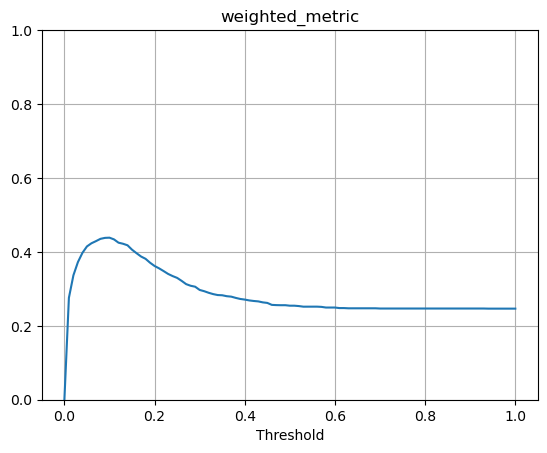

In [20]:
threshold_score['weighted_metric'].plot(grid=True, ylim=[0,1]).set_title('weighted_metric')

In [21]:
threshold_score.iloc[threshold_score['weighted_metric'].argmax()]

miss_changes                     250.000000
miss_changed_ratio                 0.032417
miss_weighted_changes          11277.000000
miss_weighted_changed_ratio        0.020568
automatized_points             22010.000000
automatized_capacity               0.551961
raw_metric                         0.373032
weighted_metric                    0.438433
Name: 0.1, dtype: float64

In [22]:
thred = threshold_score.iloc[threshold_score['weighted_metric'].argmax()].name
print("The best threshold for the model is {:1.3f}.".format(thred))

0.1

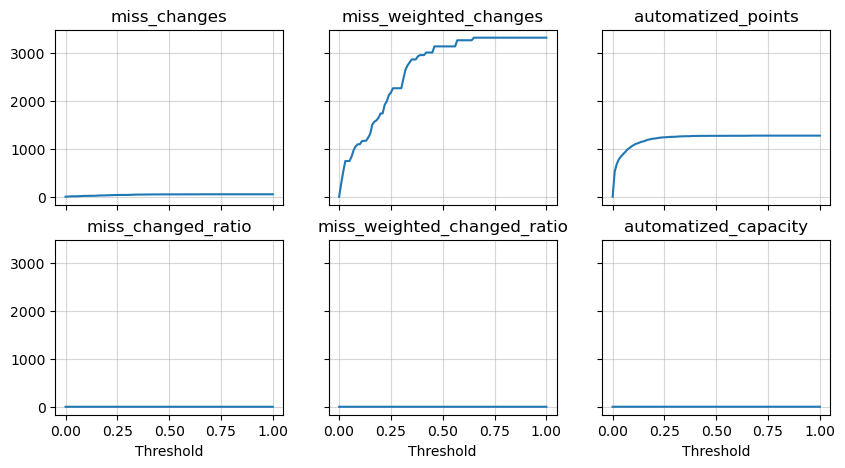

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))

col_plot = ['miss_changes', 'miss_weighted_changes', 'automatized_points',
            'miss_changed_ratio','miss_weighted_changed_ratio',  'automatized_capacity']

major_ticks = np.linspace(0,1,5)

for axe, col in zip(axs.flat, col_plot):
    threshold_score[col].plot(ax=axe, grid = True)
    axe.set_title(col)
    axe.set_xticks(major_ticks)    
    axe.grid(which='major', alpha=0.5)